这是一个定制化的对股票估值的『毛估估』算法，主要是解决个人的两个需求，
1. 对不赢利的年轻公司进行估值；
2. 将不成熟的、成熟的、低增长的不同公司股票放在一起比较（虽然定量的比较一定是不太靠谱的）。

大体的做法是，
1. 在通常的DCF方法中假设的『快速成长阶段』之前，增加了一个『不稳定成长阶段』；
2. 在『不稳定成长阶段』中，通常处于亏损状态，因为需要投入大量成本来扩大生产和建立市场地位，随着销售规模的快速扩张带来营收的高速增长，同时成本不会以相同的速度增长，从而在期末实现一个合理的利润率；
3. 在『快速成长阶段』中，我们假设企业通过将绝大部分利润投入了再生产，通过提升销量、提高定价、优化成本等方法实现收益的稳定增长。因此不计入此阶段各年收益，这与传统做法有所区别。
4. 公平起见，『不稳定成长阶段』和『快速成长阶段』共享总年数

具体细节可见下文代码及注释。

In [1]:
# 环境和包配置
import pandas as pd
import matplotlib.pyplot as plt

from value_analysis import crawler
from value_analysis.common import *
from value_analysis.valuation import *

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
pd.set_option( 'display.precision',2)

In [2]:
# 全局参数
global_config_table = read_csv(
"""
,                    默认
成长阶段总年数,        10.0
Terminal.年数,       10.0
Terminal.增长率,      0.04
折现率,               0.1
"""
)

# 各公司配置数据
# ------
# 相较于传统的DCF计算, 在快速成长阶段和永续增长阶段之外, 增加了一个不稳定成长阶段, 主要是为了支持对不赢利或赢利不稳定的"年轻"公司的估值.
# 公平起见, 这个阶段与快速成长阶段共享总年数, 其期末EPS的估计需要根据个人对特定公司的理解来定, 也是这个毛估估方法的核心.
# -------
# Unstable.年数: 成熟公司设置为0; 未赢利公司考虑公司发展情况设置
# Unstable.期末EPS: 成熟公司设置为近期财报公布的扣非每股收益; 未赢利公司根据营收等预期估算, 在数据表中作相应说明
# Rapid.增长率: 成熟公司参考10年扣非每股收益增长率; 未赢利公司可参考行业内成熟企业的数值

config_table = {}

config_table["2022Q4"] = read_csv(
"""
名称,    Unstable.年数,   Unstable.增长率,  Unstable.期末利润率,   Rapid.增长率
网易,      0,              0,               0,                   16.6
腾讯,      0,              0,               0,                   20.0
快手,      4.75,           20.0,            20.0,                16.6          # 近3年营收增长率66.5%, 近1年13.4%; 行业20%的净利率
京东,      1.75,           30.0,            2.5,                 16.6          # 近5年营收增长率43.2%, 近3年19.4%, 近1年-1.9%; 略低于同行costco的净利率2.5%
美团,      1.75,           30.0,            20.0,                20.0          # 近5年营收增长率58.3%, 近3年10.1%, 近1年26.6%, 线下优势强劲; 行业20%净利率
拼多多,    1.75,           50.0,            24.0,                20.0          # 近5年营收增长率96.4%, 近3年51.8%, 近1年25.9%, 海外进展迅速; 行业20%净利率
苹果,      0,              0,               0,                   14.9
微软,      0,              0,               0,                   16.8
"""
)

config_table["2023Q1"] = read_csv(
"""
名称,     Unstable.年数,   Unstable.增长率,  Unstable.期末利润率,   Rapid.增长率
腾讯,       0,              0,               0,                  16.6
快手,       4.5,            20.0,            20.0,               16.6          # 近3年营收增长率66.5%, 近1年13.4%; 行业20%的净利率
京东,       1.5,            20.0,            2.5,                16.6          # 近5年营收增长率43.2%, 近3年19.4%, 近1年-1.9%; 略低于同行costco的净利率2.5%
美团,       1.5,            30.0,            20.0,               16.6          # 近5年营收增长率58.3%, 近3年10.1%, 近1年26.6%, 线下优势强劲; 行业20%净利率
拼多多,     1.5,            50.0,            24.0,               16.6          # 近5年营收增长率96.4%, 近3年51.8%, 近1年25.9%, 海外进展迅速; 近期净利率超过25%, 行业20%净利率
"""
)

config_table["2023Q2"] = read_csv(
f"""
名称,   Unstable.年数,   Unstable.增长率,  Unstable.期末利润率,   Rapid.增长率
快手,     4.25,            20.0,            20.0,                16.6          # 近3年营收增长率66.5%, 近1年13.4%; 行业20%的净利率
京东,     1.25,            20.0,            2.5,                 16.6          # 近5年营收增长率43.2%, 近3年19.4%, 近1年-1.9%; 略低于同行costco的净利率2.5%
美团,     1.25,            30.0,            20.0,                16.6          # 近5年营收增长率58.3%, 近3年10.1%, 近1年26.6%, 线下优势强劲; 行业20%净利率
拼多多,   1.25,            50.0,            0,                   16.6          # 近5年营收增长率96.4%, 近3年51.8%, 近1年25.9%, 海外进展迅速; 近期净利率超过25%, 行业20%净利率
英伟达,   0,               0,               0,                   36            # 近一年利润增长率接近36%, 这种高速能持续 5-10 年吗, 不太确定, 估且先用来算着
"""
)

config_table["2023Q3"] = read_csv(
f"""
名称,    Unstable.年数,   Unstable.增长率,  Unstable.期末利润率,   Rapid.增长率
快手,      4,            20.0,            20.0,                16.6          # 近3年营收增长率66.5%, 近1年13.4%; 行业20%的净利率; Q3 营收同比增长rmb 20.84%(hkd 17.46%), 经营利润率来到3.47%, 还有很大提升空间
京东,      1,            20.0,            2.5,                 16.6          # 近5年营收增长率43.2%, 近3年19.4%, 近1年-1.9%; 略低于同行costco的净利率2.5%, 目前已接近目标
美团,      1,            30.0,            20.0,                16.6          # 近5年营收增长率58.3%, 近3年10.1%, 近1年26.6%; 行业20%净利率; 线下优势受到挑战, 营收增速放缓
拼多多,    1,            50.0,               0,                16.6          # 近5年营收增长率96.4%, 近3年51.8%, 近1年53.6%, 海外进展迅速; 近期净利率超过25%, 行业20%净利率
苹果,      0,              0,                0,                16.6
微软,      0,              0,                0,                16.6
英伟达,    0,              0,                0,                30             # 近一年利润增长率接近173.2%, 3年 24%, 5年 18%, 考虑到 AI 行业的爆发，先用 30% 算吧
"""
)

config_table["2023Q4"] = read_csv(
f"""
名称,   Unstable.年数,   Unstable.增长率,  Unstable.期末利润率,   Rapid.增长率
快手,    3.75,            20.0,            20.0,                16.6          # 近3年营收增长率66.5%, 近1年13.4%; 行业20%的净利率; Q3 营收同比增长rmb 20.84%(hkd 17.46%), 经营利润率来到3.47%, 还有很大提升空间
京东,    0.75,            20.0,            2.5,                 16.6          # 近5年营收增长率43.2%, 近3年19.4%, 近1年-1.9%; 略低于同行costco的净利率2.5%, 目前已接近目标
美团,    0.75,            30.0,            20.0,                16.6          # 近5年营收增长率58.3%, 近3年10.1%, 近1年26.6%; 行业20%净利率; 线下优势受到挑战, 营收增速放缓
拼多多,  0.75,            50.0,               0,                16.6          # 近5年营收增长率96.4%, 近3年51.8%, 近1年53.6%, 海外进展迅速; 近期净利率超过25%, 行业20%净利率
"""
)

# 对 RMB 汇率
fx_table = read_csv(
"""
名称,   2022Q4, 2023Q1, 2023Q2, 2023Q3, 2023Q4
HKD,   0.8749, 0.9254, 0.9323, 0.9090, 0.9228
USD,   6.8676, 7.2516, 7.3010, 7.0978, 7.2203
""")

# 各公司价格数据
prices_table = read_csv(
"""
名称,   20230216,   20230322,    20230530,  20230918,   20231229, 20240408
网易,   138.2,      134.0,       139.5,     158.3,      140.6,    151.3
腾讯,   382.6,      347.2,       316.2,     312.2,      293.6,    305.4
快手,   61.9,       54,          54.5,      63.7,       52.95,    49.6
京东,   212.6,      152.9,       130.0,     121.0,      112.5,    102.3
美团,   148.3,      130.3,       116.4,     122.0,      81.9,     99.4
拼多多, 94.46,      78.93,       71.42,     99.81,      146.31,   117.62
苹果,   155.33,     159.28,      175.43,    177.97,     192.53,   168.45
微软,   269.32,     273.78,      332.89,    329.06,     376.04,   424.59
英伟达, 219.939,    264.627,     401.03,    439.66,     495.22,   871.33
""")

global_config:


,默认
成长阶段总年数,10.00
Terminal.年数,10.00
Terminal.增长率,0.04
折现率,0.10


,2022Q1,2022Q2,2022Q3,2022Q4,2023Q1,2023Q2,2023Q3,2023Q4
网易,235.56,231.59,244.27,253.54,250.46,240.11,272.70,271.40
腾讯,1354.71,1340.34,1400.93,1449.54,1499.86,1492.08,1546.25,1551.96
快手,210.67,216.95,231.28,282.93,252.17,277.44,279.48,325.61
京东,2396.55,2676.00,2435.35,2954.46,2429.56,2879.31,2476.98,3060.77
美团,462.69,509.38,NaN,NaN,586.17,679.65,NaN,NaN
拼多多,237.94,314.40,355.04,398.20,376.37,522.81,688.40,888.81
苹果,972.78,829.59,901.46,1171.54,948.36,817.97,894.98,1195.75
微软,493.60,518.65,501.22,527.47,528.57,561.89,565.17,620.20
英伟达,82.88,67.04,59.31,60.51,71.92,135.07,181.20,221.03


Data 2023Q3:


,期初RPS,Unstable.年数,Unstable.增长率,Unstable.期末利润率,Unstable.期末EPS,Rapid.增长率,Rapid.期末EPS,内在价值,现价,安全边际%,估测PE
名称,,,,,,,,,,,
网易,34.7,0.0,0.0,26.34,9.14,16.6,42.46,121.82,151.30,-24.2,16.55
腾讯,69.74,0.0,0.0,32.48,22.65,16.6,105.21,301.83,305.40,-1.18,13.48
快手,27.66,4.0,20.0,20.00,11.47,16.6,28.83,82.7,49.60,40.02,7.99
京东,371.6,1.0,20.0,2.50,11.15,16.6,44.41,127.41,102.30,19.71,10.7
美团,NaN,1.0,30.0,20.00,NaN,16.6,NaN,NaN,99.40,NaN,NaN
拼多多,21.06,1.0,50.0,23.27,7.35,16.6,29.28,83.99,117.62,-40.04,18.66
苹果,24.82,0.0,0.0,25.31,6.28,16.6,29.18,83.71,168.45,-101.24,26.82
微软,29.38,0.0,0.0,35.31,10.38,16.6,48.2,138.27,424.59,-207.08,40.92
英伟达,17.95,0.0,0.0,42.09,7.56,30.0,104.15,298.81,871.33,-191.6,115.33


Data 2023Q4:


,期初RPS,Unstable.年数,Unstable.增长率,Unstable.期末利润率,Unstable.期末EPS,Rapid.增长率,Rapid.期末EPS,内在价值,现价,安全边际%,估测PE
名称,,,,,,,,,,,
网易,34.78,0.00,0.0,28.43,9.89,16.6,45.93,131.78,151.30,-14.81,15.3
腾讯,69.87,0.00,0.0,18.92,13.22,16.6,61.4,176.16,305.40,-73.37,23.1
快手,28.31,3.75,20.0,20.00,11.22,16.6,29.29,84.04,49.60,40.98,7.86
京东,369.66,0.75,20.0,2.50,10.6,16.6,43.86,125.84,102.30,18.7,10.83
美团,NaN,0.75,30.0,20.00,NaN,16.6,NaN,NaN,99.40,NaN,NaN
拼多多,25.82,0.75,50.0,24.24,8.48,16.6,35.11,100.73,117.62,-16.77,15.56
苹果,24.98,0.00,0.0,26.16,6.54,16.6,30.36,87.09,168.45,-93.43,25.78
微软,30.63,0.00,0.0,36.27,11.11,16.6,51.6,148.03,424.59,-186.82,38.22
英伟达,24.37,0.00,0.0,48.85,11.9,30.0,164.1,470.79,871.33,-85.08,73.2


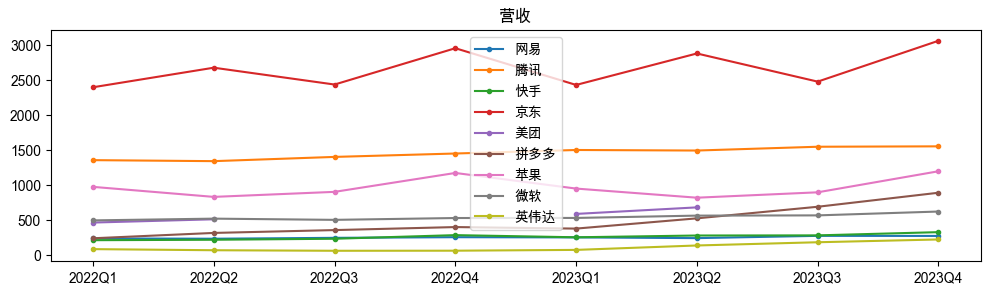

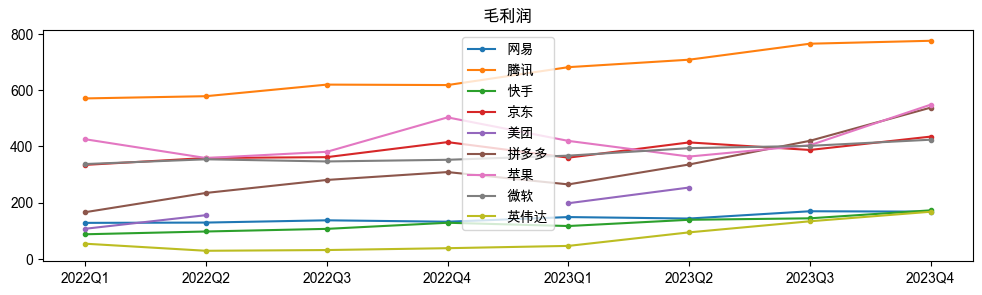

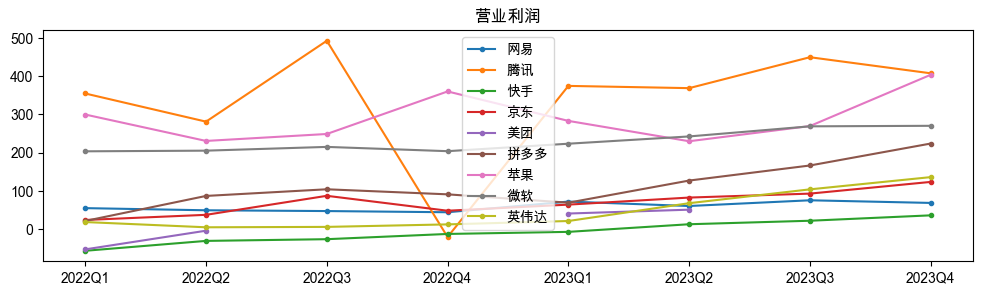

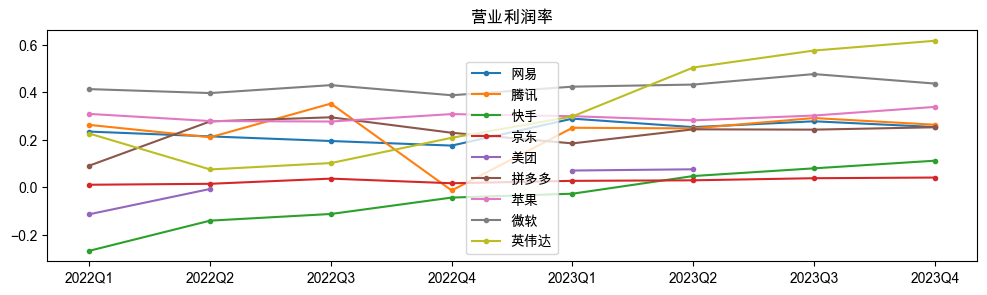

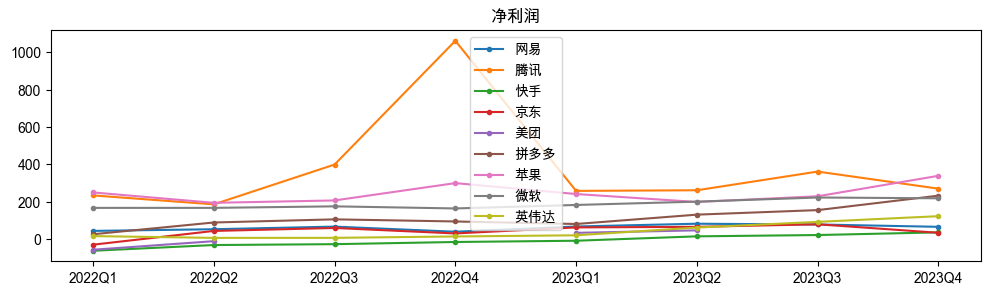

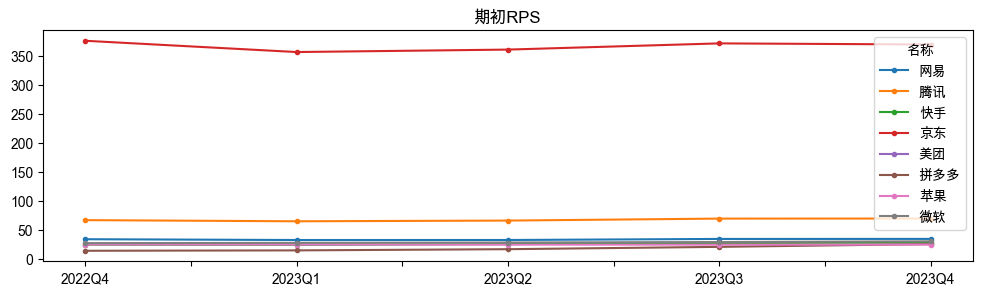

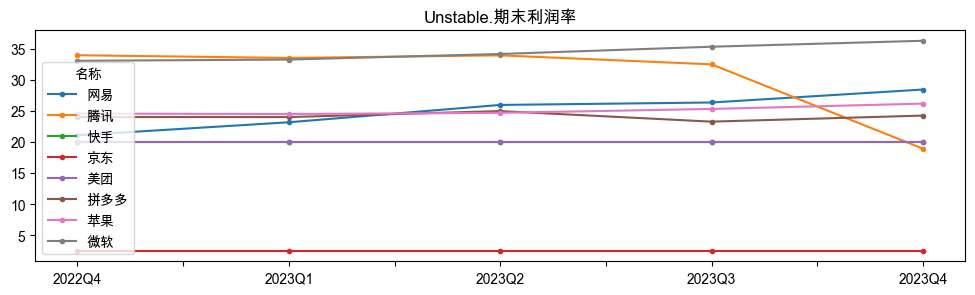

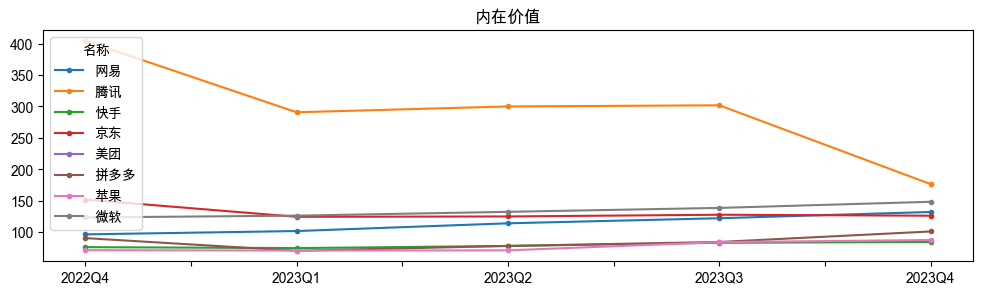

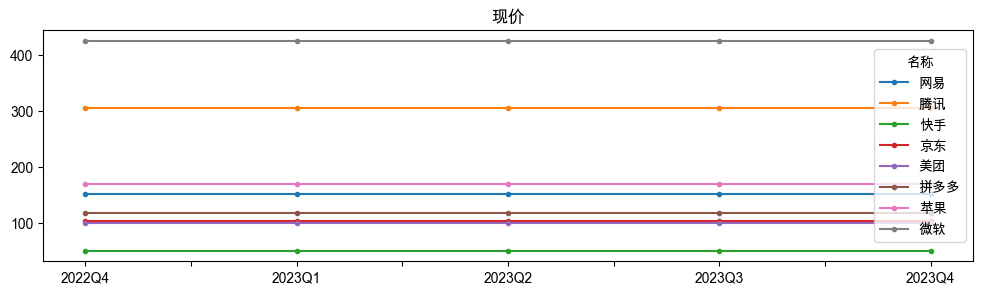

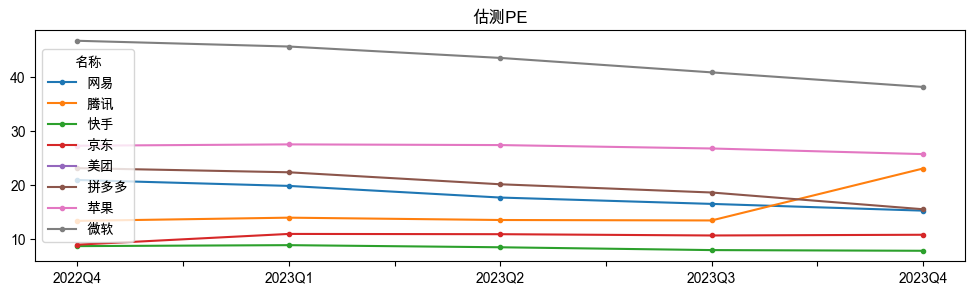

In [3]:
# 计算全局参数
global_config = global_config_table["默认"];

print("global_config:")
display(global_config.to_frame())

# 读取合并财报数据
reports = { stock_name : crawler.load_report(row["代码"]) for stock_name, row in stock_table.iterrows() }
income_table = pd.DataFrame({stock_name : report.loc["营收"]/1e8 for stock_name, report in reports.items()}).T
gross_profit_table = pd.DataFrame({stock_name : report.loc["毛利润"]/1e8 for stock_name, report in reports.items()}).T
op_profit_table = pd.DataFrame({stock_name : report.loc["营业利润"]/1e8 for stock_name, report in reports.items()}).T
net_profit_table = pd.DataFrame({stock_name : report.loc["净利润"]/1e8 for stock_name, report in reports.items()}).T
shares_table = pd.DataFrame({stock_name : report.loc["股本"]/1e8 for stock_name, report in reports.items()}).T
income_ttm_table = income_table.T.rolling(window=4, min_periods=4).sum().T.iloc[:, 3:]
net_profit_ttm_table = net_profit_table.T.rolling(window=4, min_periods=4).sum().T.iloc[:, 3:]
display(income_table)

# 合并特征
keys = sorted(config_table.keys())
merged_config_table: dict[str, pd.DataFrame] = {}
last_key = None
# 合并配置
for key in keys:
    if last_key:
        merged_config_table[key] = merged_config_table[last_key].copy()
        for index, row in config_table[key].iterrows():
            merged_config_table[key].loc[index] = row
    else:
        merged_config_table[key] = config_table[key]
    last_key = key

# 合入财务数据
feature_table = {}
for key in keys:
    rps = income_ttm_table[key]/shares_table[key]
    profit_rate = net_profit_ttm_table[key]/income_ttm_table[key]*100
    feature_table[key] = merged_config_table[key].copy()
    feature_table[key].insert(0, "期初RPS", {})  # 在开头插入新列
    for index, row in feature_table[key].iterrows():
        # 补充 RPS
        fx = stock_table.at[index, "外汇"]
        if isinstance(fx, str) and fx:
            fx_rate = fx_table.at[fx, key]
            feature_table[key].at[index, "期初RPS"] = rps[index] / fx_rate
        else:
            feature_table[key].at[index, "期初RPS"] = rps[index]
        # 补充 利润率
        if row["Unstable.期末利润率"] == 0:
            feature_table[key].at[index, "Unstable.期末利润率"] = profit_rate[index]

# 计算打印各公司估值
outputs: dict = {}
for key in keys:
    outputs[key] = perform_valuation(global_config, feature_table[key], prices_table["20240408"])

for key in keys[-2:]:
    print(f"Data {key}:")
    display(outputs[key])

# 打印财务趋势
income_table.T.plot(marker='.', layout=(2, 4), subplots=False, figsize=(12, 3))
plt.title("营收")
gross_profit_table.T.plot(marker='.', layout=(2, 4), subplots=False, figsize=(12, 3))
plt.title("毛利润")
op_profit_table.T.plot(marker='.', layout=(2, 4), subplots=False, figsize=(12, 3))
plt.title("营业利润")
(op_profit_table/income_table).T.plot(marker='.', layout=(2, 4), subplots=False, figsize=(12, 3))
plt.title("营业利润率")
net_profit_table.T.plot(marker='.', layout=(2, 4), subplots=False, figsize=(12, 3))
plt.title("净利润")
prices_table.T.plot(marker='.', layout=(2, 4), subplots=False, figsize=(12, 3))
plt.title("现价")

trends_keys = ["期初RPS", "Unstable.期末利润率", "内在价值", "估测PE"]
trends: dict[str, pd.DataFrame] = {k: pd.DataFrame() for k in trends_keys}
for i in sorted(outputs.keys()):
    for j in trends.keys():
        trends[j][i] = outputs[i][j]

for j in trends.keys():
    trends[j].T.plot(marker='.', layout=(2, 4), subplots=False, figsize=(12, 3))
    plt.title(j)
